In [1]:
import random
import os
import re
import numpy as np
from time import time
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack, issparse, coo_matrix
from string import punctuation
from collections import defaultdict, Counter
from copy import deepcopy
import matplotlib.pyplot as plt

Загружаем данные. У нас есть три выборки: обучающая (train), валидационная (dev) и тестовая (test). На валидационной выборке тестируем классификатор и подбираем гиперпараметры. Результаты работы классификатора на тестовой выборке проверяются на сервере СompAI, метки для нее не предоставляются.

In [2]:
data_dir = '../FILIMDB'

In [3]:
def load_data(file_name):
    """
    Reads specified file, returns list of strings
    :param file_name: file name in data_dir folder
    :returns list of strings
    """
    print('Loading %s' % file_name)
    data_path = os.path.join(data_dir, file_name)
    with open(data_path, 'r', encoding='utf8') as input_data:
        lines = input_data.readlines()
        lines = [l.strip() for l in lines]
    
    print('Loaded %d lines' % len(lines))
    return lines

In [4]:
train_texts, train_labels = load_data('train.texts'), load_data('train.labels')
dev_texts, dev_labels = load_data('dev.texts'), load_data('dev.labels')
test_texts = load_data('test.texts')

Loading train.texts
Loaded 25000 lines
Loading train.labels
Loaded 25000 lines
Loading dev.texts
Loaded 25000 lines
Loading dev.labels
Loaded 25000 lines
Loading test.texts
Loaded 10599 lines


Посмотрим, какие символы встречаются у нас в текстах, выберем из них те, которые мы хотим оставить

In [5]:
char_set = set(ch for review in train_texts for ch in review)
sorted_chars = sorted(list(char_set))
print(''.join(sorted_chars))

	 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¦§¨«­®°³´·º»½¾¿ÀÁÃÄÅÈÉÊÕØÜßàáâãäåæçèéêëìíîïðñòóôöøùúûüýō–‘’“”…₤


### A 

In [6]:
def tokenize(text):
    """
    Preprocesses text and split it into the list of words
    :param: text(str): movie review
    """
    # YOUR CODE HERE
    return re.findall('[\w]+', text.lower())

def get_ngrams(tokens, ngram_range):
    return [" ".join(tokens[idx:idx+i]) 
            for i in range(ngram_range[0],ngram_range[1]+1) 
            for idx in range(len(tokens)-i+1)]

def get_tokens(texts, ngram_range=(1,1)):
    return [get_ngrams(tokenize(r), ngram_range) for r in texts]

ngram_range = (1, 1)
tokenized_train_texts = get_tokens(train_texts, ngram_range)
tokenized_dev_texts = get_tokens(dev_texts, ngram_range)
tokenized_test_texts = get_tokens(test_texts, ngram_range)

Составим словарь из наиболее часто встречающихся в отзывах слов. Может быть полезно удалить из словаря стоп-слова - самые частые слова языка, не несущие важной информации для классификации (например "you", "the", "i" ...). Слова, не вошедшие в словарь, будем обозначать специальным символом "UNK"

Количество слов в словаре - важный гиперпараметр классификатора.

### B 
**Вопрос 1:** Чему равен размер получившегося словаря?

In [7]:
def get_vocab():
    with open("../stopwords.txt", "r") as f:
        STOPWORDS = map(lambda x: x.strip(), f.readlines())

    STOPWORDS = set(STOPWORDS)

    vocab = []

    for txt in tokenized_train_texts:
        vocab.extend([w for w in txt if w not in STOPWORDS])

    vocab = set(vocab) # for faster searching
    print('1. Ответ 1: размер словаря - %d' % len(vocab))
    return vocab
vocab = get_vocab()

Ответ 1: размер словаря - 74739


### C 

In [8]:
def get_matrix():
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in tqdm_notebook(tokenized_train_texts):
        for term in d:
            if term in vocab:
                index = vocabulary.setdefault(term, len(vocabulary))
                indices.append(index)
                data.append(1)
        indptr.append(len(indices))

    X_train = csr_matrix((data, indices, indptr), dtype=int)

    indptr = [0]
    indices = []
    data = []
    for d in tqdm_notebook(tokenized_dev_texts):
        for term in d:
            if term in vocab:
                index = vocabulary.setdefault(term, len(vocabulary))
                indices.append(index)
                data.append(1)
        indptr.append(len(indices))

    X_dev = csr_matrix((data, indices, indptr), shape=X_train.shape, dtype=int)
    
    return X_train, X_dev, vocabulary
X_train, X_dev, vocabulary = get_matrix()

In [9]:
y_train = np.array([(lambda l: 1 if l=='pos' else 0)(l) for l in train_labels])
y_dev = np.array([(lambda l: 1 if l=='pos' else 0)(l) for l in dev_labels])

In [10]:
X_train.shape, y_train.size

((25000, 74739), 25000)

## D
**Вопрос 2:** Во сколько раз  медленнее считается оценочная функция, если реализовать суммирование с помощью цикла?

In [72]:
class LogReg:
    def __init__(self, lr=1e-3, C=1e-3, epochs=1000):
        self.lr = lr
        self.C = C
        self.epochs = epochs
        
        self.sparse = False
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []        
        
    def __sigmoid(self, z): 
        return 1./(1+np.exp(-z))
    
    def __init_weights(self):
        self.w = np.zeros(self.n_features+1)
        self.m = np.zeros(self.n_features+1)
        self.v = np.zeros(self.n_features+1)
    
    def __h(self, x):
        return self.__sigmoid(x)
    
    def __loss(self, h, y):
        return -(y*np.log(h+1e-8)+(1-y)*np.log(1-h+1e-8)).mean() + (self.C*self.w**2).sum()
    
    def __loss_slow(self, h, y):
        s = 0
        s2 = 0
        L = -(y*np.log(h+1e-8)+(1-y)*np.log(1-h+1e-8))
        L2 = (self.C*self.w**2)
        for n in L:
            s += n
        s /= len(L)
        for n in L2:
            s2 += n
        return s + s2
    
    def __grad(self, X, h, y):
        self.gradient = X.T.dot(h-y)/y.size + 2*self.C*self.w
    
    def __step(self):
        self.w -= self.lr*self.gradient
        
        
    def fit(self, X_train, y_train, X_test, y_test):
        start = time()
        self.n_samples, self.n_features = X_train.shape
        if issparse(X_train):
            self.sparse = True
        if self.sparse:
            X_train = hstack([np.ones((self.n_samples, 1)), X_train])
            X_test = hstack([np.ones((self.n_samples, 1)), X_test])
            #X = hstack((X,np.ones(self.n_samples)[:,None]))
        else:
            X_train = np.concatenate((np.ones((self.n_samples, 1)), X_train), axis=1)
            X_test = np.concatenate((np.ones((self.n_samples, 1)), X_test), axis=1)
        
        self.__init_weights()
        for i in tqdm_notebook(range(self.epochs)):
            z = X_train.dot(self.w)
            h = self.__sigmoid(z)
            self.__grad(X_train, h, y_train)
            self.__step()
            
            if(i % 1000 == 0):
            #print(f'loss: {self.__loss(z, y)} \t')
                self.train_losses.append(self.__loss(h, y_train))
                self.train_acc.append((y_train == h.round()).mean())
            
                z = X_test.dot(self.w)
                h = self.__sigmoid(z)
                self.test_losses.append(self.__loss(h, y_test))
                self.test_acc.append((y_test == h.round()).mean())
        
        t = time() - start
        print('Модель обучилась за %d минут и %d секунд' %(t//60, t%60))
    
    def compare(self, X_train, y_train):
        self.n_samples, self.n_features = X_train.shape
        X_train = hstack([np.ones((self.n_samples, 1)), X_train])
        self.__init_weights()
        z = X_train.dot(self.w)
        h = self.__sigmoid(z)
        
        start = time()
        for i in range(100):
            self.__loss(h, y_train)
        fast = time() - start
        
        start = time()
        for i in range(100):
            self.__loss_slow(h, y_train)
        slow = time() - start
        
        print("2. Ответ: Матричные операции для функции потерь быстрее в  %f раз" %(slow/fast))
        
        
    def predict_prob(self, X):
        self.n_samples, self.n_features = X.shape
        if issparse(X):
            self.sparse = True
        if self.sparse:
            X = hstack([np.ones((self.n_samples, 1)), X])
    
        return self.__sigmoid(X.dot(self.w))
    
    def predict(self, X):
        return self.predict_prob(X).round()
    
    def score(self, X, y):
        return (y == self.predict(X)).mean()

In [73]:
def plot(model):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(model.train_losses, label='Train')
    plt.plot(model.test_losses, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(model.train_acc, label='Train accuracy')
    plt.plot(model.test_acc, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.ylim(0.8, 1.0)
    plt.grid()
    plt.show()

In [74]:
model = LogReg(lr=1e-3, C=1e-5, epochs=10000)
model.compare(X_train, y_train)

2. Ответ: Матричные операции для функции потерь быстрее в  16.372434 раз


## E
**Вопрос 3:** Через сколько эпох обучение сходится (оценочная функция перестает меняться)? Приведите графики для нескольких различных значений learning rate. Какие выводы можно сдеать относительно зависимости процесса обучения от learnig rate? 

**Вопрос 4:** Какой точности классификатора вам удалось достичь на обучающей и тестовой выборке? Имеет ли место переобучение классификатора или недообучение? Что нужно сделать с α, чтобы улучшить результат?


Модель обучилась за 10 минут и 54 секунд


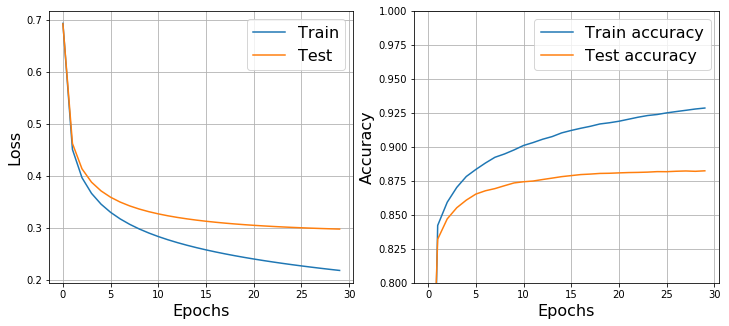

Params: lr - 1E-02, alpha - 1E-05
Score: train - 0.929720, test - 0.882640



Модель обучилась за 11 минут и 1 секунд


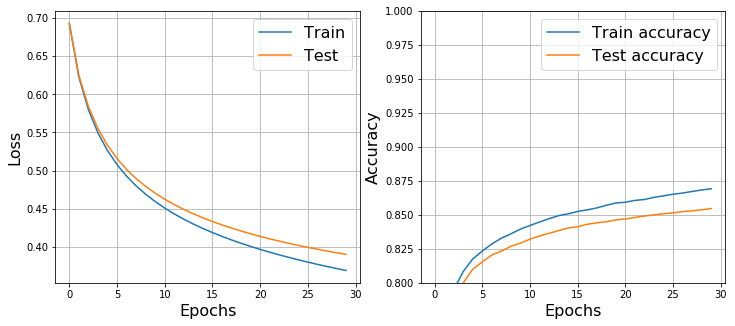

Params: lr - 1E-03, alpha - 1E-05
Score: train - 0.870200, test - 0.855240


In [75]:
for lr in [1e-2, 1e-3]:
    for alpha in [1e-5]:
        model = LogReg(lr=lr, C=alpha, epochs=30000)
        model.fit(X_train, y_train, X_dev, y_dev)
        plot(model)
        print("Params: lr - %.0E, alpha - %.0E" %(lr, alpha))
        print('Score: train - %f, test - %f' %(model.score(X_train, y_train), model.score(X_dev, y_dev)))

3. Ответ: Обучение не сходится и после 30000 итераций. Вывод: чем меньше lr, тем быстрее сходимость
4. Ответ: при таких параметрах была достигнута точность в 0.92 на обучающей и 0.88 на тестовой выборках. Имеент место недообучение классификатора. Для улучшения качества надо увеличить alpha и число итераций

## F
**Вопрос 5:** Чему равно оптимальное значение α?

5. Ответ: графики подбора alpha есть в исследовательской части. При небольшом числе итераций лучшим оказалось значение 1e-3, при большом - 1e-5

## G
**Вопрос 6:** Оцените чему равна точность классификатора на обучающей и тестовой выборке? 

**Вопрос 7:** Сколько времени занимает обучение классификатора и предсказание результатов для тестовой выборке?

6. Ответ: точность на обучающей - 0.92, на тестовой - 0.88

In [77]:
%time model.predict(X_dev)

Wall time: 84.7 ms


array([0., 1., 1., ..., 0., 0., 1.])

7. Ответ: обучение занимает 11 минут, предсказание занимает 85 милисекунд

## H
**Вопрос 8:** Распечатайте 20 наиболее весомых признаков для позитивного и негативного класса.

In [78]:
pos_words = list(reversed(model.w.argsort()[-15:]))
neg_words = model.w.argsort()[:15]
inversed_vocabulary = {v:k for k,v in vocabulary.items()}

8. Ответ: самые позитивные

In [79]:
for p in pos_words:
    print(inversed_vocabulary[p])

adopted
10
donna
comic
later
sublime
heard
illnesses
mom
entertained
accused
summer
total
appreciate
dramatic


8. Ответ: самые негативные

In [80]:
for n in neg_words:
    print(inversed_vocabulary[n])

kate
eerie
lemon
mean
dubbing
delivering
ok
studying
constructed
terminating
avoid
beginning
3
realized
average
